In [ ]:
!pip3 install xgboost

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
# from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv('D:/Projects/Deep Learning 101/gtzan_features.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,label
0,blues.00024.wav,661500,0.263108,0.099980,0.086962,0.002512,1120.390980,176408.836176,1447.852625,53821.613990,...,94.161580,-2.302590,68.893074,3.783148,76.785670,0.084823,73.574780,-0.939437,126.729645,blues
1,blues.00027.wav,661500,0.288705,0.094162,0.095725,0.002194,1391.443904,200153.143237,1494.850834,43500.503910,...,61.917267,-9.396027,85.992905,-2.562838,107.918915,-4.522896,59.029346,-0.262949,67.838790,blues
2,blues.00074.wav,661500,0.367174,0.085402,0.196903,0.004284,2515.869160,272550.358669,2531.420001,66559.812170,...,85.300290,12.328122,65.853590,-13.717032,65.636055,11.850821,70.903915,-3.982272,58.626965,blues
3,blues.00075.wav,661500,0.466458,0.081497,0.192030,0.008019,2225.176866,462553.522638,2255.135044,99000.271768,...,73.999756,15.339354,75.326546,-7.049362,83.158050,12.182225,61.919407,-6.110912,92.456580,blues
4,blues.00011.wav,661500,0.365807,0.102007,0.065685,0.002501,1353.329119,511903.711272,1757.331004,220219.000176,...,148.787000,6.566734,114.196280,-4.879438,93.832950,-3.180660,84.243774,-5.557003,65.379010,blues


In [4]:
df.shape

(999, 46)

In [5]:
df.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                       object
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [6]:
df = df.drop(['filename', 'tempo'], axis=1)
df.shape

(999, 44)

In [7]:
df = pd.get_dummies(df, columns=['label'])
df.shape

(999, 53)

In [8]:
df.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,label_blues,label_classical,label_country,label_disco,label_hiphop,label_jazz,label_metal,label_pop,label_reggae,label_rock
0,661500,0.263108,0.099980,0.086962,0.002512,1120.390980,176408.836176,1447.852625,53821.613990,2325.127607,...,True,False,False,False,False,False,False,False,False,False
1,661500,0.288705,0.094162,0.095725,0.002194,1391.443904,200153.143237,1494.850834,43500.503910,2811.141335,...,True,False,False,False,False,False,False,False,False,False
2,661500,0.367174,0.085402,0.196903,0.004284,2515.869160,272550.358669,2531.420001,66559.812170,5771.615100,...,True,False,False,False,False,False,False,False,False,False
3,661500,0.466458,0.081497,0.192030,0.008019,2225.176866,462553.522638,2255.135044,99000.271768,4703.588225,...,True,False,False,False,False,False,False,False,False,False
4,661500,0.365807,0.102007,0.065685,0.002501,1353.329119,511903.711272,1757.331004,220219.000176,2882.315904,...,True,False,False,False,False,False,False,False,False,False


In [9]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=df.filter(like='label_').columns)
y = df.filter(like='label_')  # One-hot encoded labels

# Split into training (75%) and testing (25%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Print shapes
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (749, 43), X_test shape: (250, 43)
y_train shape: (749, 10), y_test shape: (250, 10)


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print batch sizes
print(f"Train DataLoader batches: {len(train_loader)}")
print(f"Test DataLoader batches: {len(test_loader)}")

Train DataLoader batches: 24
Test DataLoader batches: 8


In [ ]:
# # Data Visualization
# # Add genre names back for visualization
# df['genre'] = le.inverse_transform(df['label'])

# # Group by genre and compute mean for selected features
# genre_means = df.groupby('genre').mean()

# # Features to visualize
# features_to_plot = ['chroma_stft_mean', 'rms_mean', 'spectral_centroid_mean', 'tempo']

# # Plot bar charts
# plt.figure(figsize=(15, 10))
# for i, feature in enumerate(features_to_plot, 1):
#     plt.subplot(2, 2, i)
#     genre_means[feature].plot(kind='bar')
#     plt.title(f'Mean {feature} by Genre')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
# plt.show()

# # Drop the temporary 'genre' column
# df = df.drop('genre', axis=1)

In [12]:
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, num_classes)
        # self.softmax = nn.Softmax(dim=1)  # Softmax for probability outputs
        # self.relu3 = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        # out = self.softmax(out)  # Apply Softmax to final logits
        # out = self.relu3(out)
        return out

best lr = 1e-3

In [13]:
# Define Hyperparameters
input_size = X_train.shape[1]  # 44 features
hidden_size1 = 256
hidden_size2 = 128
num_classes = 10  # 10 genres
learning_rate = 0.0005
num_epochs = 175

# Initialize the model
model = ANN(input_size, hidden_size1, hidden_size2, num_classes)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Hyperparameters set. Using device: {device}")

Hyperparameters set. Using device: cuda


In [14]:
train_losses = []
val_losses = []
clip_value = 1.0  # Set a reasonable clipping value

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)

        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # # Validation phase
    # model.eval()
    # val_loss = 0.0
    # with torch.no_grad():
    #     for inputs, labels in val_loader:
    #         inputs, labels = inputs.to(device), labels.to(device)
    #         outputs = model(inputs)
    #         loss = criterion(outputs, labels)
    #         val_loss += loss.item()

    # val_loss /= len(val_loader)
    # val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")

Epoch [1/175], Train Loss: 2.1334
Epoch [2/175], Train Loss: 1.7252
Epoch [3/175], Train Loss: 1.4299
Epoch [4/175], Train Loss: 1.2404
Epoch [5/175], Train Loss: 1.1145
Epoch [6/175], Train Loss: 1.0240
Epoch [7/175], Train Loss: 0.9310
Epoch [8/175], Train Loss: 0.8542
Epoch [9/175], Train Loss: 0.8024
Epoch [10/175], Train Loss: 0.7418
Epoch [11/175], Train Loss: 0.7088
Epoch [12/175], Train Loss: 0.6649
Epoch [13/175], Train Loss: 0.6219
Epoch [14/175], Train Loss: 0.5893
Epoch [15/175], Train Loss: 0.5641
Epoch [16/175], Train Loss: 0.5432
Epoch [17/175], Train Loss: 0.5129
Epoch [18/175], Train Loss: 0.4912
Epoch [19/175], Train Loss: 0.4610
Epoch [20/175], Train Loss: 0.4518
Epoch [21/175], Train Loss: 0.4183
Epoch [22/175], Train Loss: 0.3981
Epoch [23/175], Train Loss: 0.3759
Epoch [24/175], Train Loss: 0.3668
Epoch [25/175], Train Loss: 0.3495
Epoch [26/175], Train Loss: 0.3232
Epoch [27/175], Train Loss: 0.3195
Epoch [28/175], Train Loss: 0.2972
Epoch [29/175], Train Loss: 0

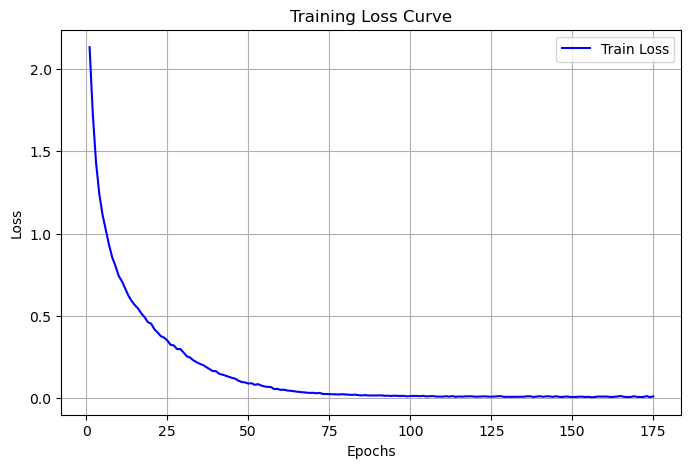

Test Accuracy: 0.7640
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.64      0.74        25
           1       0.83      0.80      0.82        25
           2       0.84      0.84      0.84        25
           3       0.67      0.64      0.65        25
           4       0.76      0.88      0.81        25
           5       0.76      0.88      0.81        25
           6       0.83      0.76      0.79        25
           7       0.88      0.84      0.86        25
           8       0.74      0.68      0.71        25
           9       0.55      0.68      0.61        25

    accuracy                           0.76       250
   macro avg       0.77      0.76      0.76       250
weighted avg       0.77      0.76      0.76       250



In [15]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report

# Plot Training Loss Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid()
plt.show()

# Model Evaluation
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)  # Convert logits to class predictions
        y_true.extend(torch.argmax(labels, dim=1).cpu().numpy())  # Convert one-hot labels to class indices
        y_pred.extend(predictions.cpu().numpy())

# Compute Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))

In [16]:
torch.save(model.state_dict(), 'ANN.pth')